In [36]:
# %%
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from chronos.base import BaseChronosPipeline
import torch
from scipy.ndimage import gaussian_filter1d
import warnings
warnings.filterwarnings('ignore')

In [37]:
# === Step 1: Load the time series ===
df = pd.read_csv("anomaly_data/realKnownCause/rogue_agent_key_hold.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])
timestamp_prova = df['timestamp'].copy()

# === Step 2: Load ground truth anomaly windows ===
with open("anomaly_data/combined_windows.json", "r") as f:
    labels_json = json.load(f)

anomaly_windows = labels_json["realKnownCause/rogue_agent_key_hold.csv"]


# === Step 3: Generate binary anomaly labels ===
def generate_binary_labels(df, anomaly_windows):
    labels = np.zeros(len(df), dtype=int)
    for start_str, end_str in anomaly_windows:
        start = pd.to_datetime(start_str)
        end = pd.to_datetime(end_str)
        mask = (df['timestamp'] >= start) & (df['timestamp'] <= end)
        labels[mask] = 1
    return labels

labels = generate_binary_labels(df, anomaly_windows)


# === Step 4: Simulate anomaly scores (placeholder for Chronos residuals or errors) ===
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",  # use "amazon/chronos-bolt-small" for the corresponding Chronos-Bolt model
    device_map="cuda:0",  # use "cpu" for CPU inference
    torch_dtype=torch.bfloat16,
)


rate_in_minutes = 5 #TODO: cambiare in base al dataset 
one_hour = int(60/ rate_in_minutes)
if rate_in_minutes == 5:
    context_length = one_hour * 24  # = un giorno di dati
else:
    context_length = one_hour * 24 * 7 # una settimana di dati
prediction_length = int(context_length / 10)  # Ridotto da 12 per detection più granulare
quantile_levels = [0.05, 0.5, 0.95]  # Bande più ampie per catturare meglio le anomalie

# === Step 5: Anomaly Detection con miglioramenti ===
def calculate_anomaly_scores_improved(df, pipeline, context_length, prediction_length, quantile_levels):
    """
    Calcola anomaly scores con vari miglioramenti
    """
    n_points = len(df)
    anomaly_scores = np.full(n_points, np.nan)  # Inizializza con NaN

    # Pre-calcola rolling statistics per normalizzazione
    values = df["value"].values
    rolling_std = pd.Series(values).rolling(window=context_length, min_periods=1).std().fillna(1.0)

    print(f"Processando {n_points - context_length - prediction_length + 1} time steps...")

    for t in range(context_length, n_points - prediction_length + 1, round(prediction_length / 4)):
        print(f"Progress: {t - context_length}/{n_points - context_length - prediction_length + 1}")

        context = values[t - context_length:t]
        target = values[t:t + prediction_length]

        # Predict with Chronos
        try:
            quantiles, _ = pipeline.predict_quantiles(
                context=torch.tensor(context, dtype=torch.float),
                prediction_length=prediction_length,
                quantile_levels=quantile_levels,
            )

            q_low, q_med, q_high = quantiles[0, :, 0], quantiles[0, :, 1], quantiles[0, :, 2]

            # Converti in numpy
            upper = q_high.numpy()
            lower = q_low.numpy()

            # Calcola anomaly score con varie strategie
            over = np.maximum(target - upper, 0)
            under = np.maximum(lower - target, 0)
            raw_errors = over + under

            # 90th percentile (robusto agli outlier)
            score_p = np.percentile(raw_errors, 90)

            # Normalizzazione per la scala locale
            local_std = rolling_std.iloc[t]
            score_normalized = score_p / (local_std + 1e-8)

            # Assegna score al punto centrale della finestra di previsione
            center_idx = t + prediction_length // 2
            anomaly_scores[center_idx] = score_normalized

        except Exception as e:
            print(f"Error at time step {t}: {e}")
            continue

    return anomaly_scores

In [38]:
print("Calculating anomaly scores...")
anomaly_scores_raw = calculate_anomaly_scores_improved(
    df, pipeline, context_length, prediction_length, quantile_levels
)

Calculating anomaly scores...
Processando 1567 time steps...
Progress: 0/1567
Progress: 7/1567
Progress: 14/1567
Progress: 21/1567
Progress: 28/1567
Progress: 35/1567
Progress: 42/1567
Progress: 49/1567
Progress: 56/1567
Progress: 63/1567
Progress: 70/1567
Progress: 77/1567
Progress: 84/1567
Progress: 91/1567
Progress: 98/1567
Progress: 105/1567
Progress: 112/1567
Progress: 119/1567
Progress: 126/1567
Progress: 133/1567
Progress: 140/1567
Progress: 147/1567
Progress: 154/1567
Progress: 161/1567
Progress: 168/1567
Progress: 175/1567
Progress: 182/1567
Progress: 189/1567
Progress: 196/1567
Progress: 203/1567
Progress: 210/1567
Progress: 217/1567
Progress: 224/1567
Progress: 231/1567
Progress: 238/1567
Progress: 245/1567
Progress: 252/1567
Progress: 259/1567
Progress: 266/1567
Progress: 273/1567
Progress: 280/1567
Progress: 287/1567
Progress: 294/1567
Progress: 301/1567
Progress: 308/1567
Progress: 315/1567
Progress: 322/1567
Progress: 329/1567
Progress: 336/1567
Progress: 343/1567
Progre

In [39]:
def post_process_scores(scores, sigma=2.0):
    """
    Post-processing degli anomaly scores
    """
    # Rimuovi NaN per calcolare statistiche
    valid_scores = scores[~np.isnan(scores)]

    if len(valid_scores) == 0:
        return scores

    # Smoothing gaussiano
    scores_filled = np.copy(scores)

    # Interpola i NaN con interpolazione lineare
    nan_mask = np.isnan(scores_filled)
    if np.any(nan_mask):
        valid_indices = np.where(~nan_mask)[0]
        if len(valid_indices) > 1:
            scores_filled = np.interp(
                np.arange(len(scores_filled)),
                valid_indices,
                scores_filled[valid_indices]
            )
        else:
            scores_filled[nan_mask] = 0

    # Applica smoothing
    scores_smooth = gaussian_filter1d(scores_filled, sigma=sigma)

    # Rimetti NaN dove erano originariamente (se vuoi mantenere i bordi)
    scores_smooth[nan_mask] = np.nan

    return scores_smooth

In [40]:
anomaly_scores_smooth = post_process_scores(anomaly_scores_raw, sigma=2.0)


In [53]:
def calculate_dynamic_threshold(scores, method='percentile', percentile=95, n_std=3):
    """
    Calcola soglia dinamica per anomaly detection
    """
    valid_scores = scores[~np.isnan(scores)]

    if len(valid_scores) == 0:
        return 0.0

    if method == 'percentile':
        threshold = np.percentile(valid_scores, percentile)
    elif method == 'iqr':
        q75, q25 = np.percentile(valid_scores, [75, 25])
        iqr = q75 - q25
        threshold = q75 + 1.5 * iqr
    else:
        threshold = np.percentile(valid_scores, 95)

    return threshold

In [54]:
threshold_p95 = calculate_dynamic_threshold(anomaly_scores_raw, 'percentile', 95)
threshold_iqr = calculate_dynamic_threshold(anomaly_scores_raw, 'iqr')

print(f"Soglie calcolate:")
print(f"  - 95th percentile: {threshold_p95:.4f}")
print(f"  - IQR method: {threshold_iqr:.4f}")

Soglie calcolate:
  - 95th percentile: 1.9708
  - IQR method: 1.0017


In [55]:
import numpy as np
import matplotlib.pyplot as plt

def plot_results(df, labels, anomaly_scores, threshold_p95, threshold_iqr, title="Anomaly Detection Results"):
    """
    Visualizza i risultati dell'anomaly detection
    """
    fig, (ax1, ax21, ax23, ax31, ax33) = plt.subplots(5, 1, figsize=(15, 18))

    # Plot 1: Serie temporale originale
    ax1.plot(df['timestamp'], df['value'], 'b-', linewidth=0.8, label='Time Series')
    anomaly_indices = np.where(labels == 1)[0]
    if len(anomaly_indices) > 0:
        ax1.scatter(df['timestamp'].iloc[anomaly_indices],
                    df['value'].iloc[anomaly_indices],
                    color='red', s=30, alpha=0.7, label='True Anomalies')
    ax1.set_ylabel('Value')
    ax1.set_title('Original Time Series with True Anomalies')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 21: Anomaly scores vs 95th percentile
    valid = ~np.isnan(anomaly_scores)
   
    ax21.plot(df['timestamp'][valid], anomaly_scores[valid], 'g-', linewidth=1, label='Anomaly Scores')
    ax21.axhline(y=threshold_p95, color='r', linestyle='--', label=f'Threshold ({threshold_p95:.4f})')
    above = anomaly_scores > threshold_p95
    if np.any(above):
        ax21.scatter(df['timestamp'][above], anomaly_scores[above], color='red', s=20, alpha=0.7, label='Detected Anomalies')
    ax21.set_ylabel('Anomaly Score')
    ax21.set_title('Anomaly Scores and Threshold (95th Percentile)')
    ax21.legend()
    ax21.grid(True, alpha=0.3)


    # Plot 23: Anomaly scores vs IQR
    ax23.plot(df['timestamp'][valid], anomaly_scores[valid], 'g-', linewidth=1, label='Anomaly Scores')
    ax23.axhline(y=threshold_iqr, color='r', linestyle='--', label=f'Threshold ({threshold_iqr:.4f})')
    above = anomaly_scores > threshold_iqr
    if np.any(above):
        ax23.scatter(df['timestamp'][above], anomaly_scores[above], color='red', s=20, alpha=0.7, label='Detected Anomalies')
    ax23.set_ylabel('Anomaly Score')
    ax23.set_title('Anomaly Scores and Threshold (IQR)')
    ax23.legend()
    ax23.grid(True, alpha=0.3)

    # Plot 31: True vs Predicted (95th Percentile)
    ax31.plot(df['timestamp'], labels, 'r-', linewidth=2, label='True Labels', alpha=0.7)
    pred_p95 = (anomaly_scores > threshold_p95).astype(int)
    mask_p95 = ~np.isnan(anomaly_scores)
    ax31.plot(df['timestamp'][mask_p95], pred_p95[mask_p95] + 0.1, 'b-', linewidth=2, label='Predicted Labels', alpha=0.7)
    ax31.set_ylabel('Binary Label')
    ax31.set_xlabel('Timestamp')
    ax31.set_title('True vs Predicted Anomalies (95th Percentile)')
    ax31.legend()
    ax31.grid(True, alpha=0.3)
    ax31.set_ylim(-0.1, 1.3)

    # Plot 33: True vs Predicted (IQR)
    ax33.plot(df['timestamp'], labels, 'r-', linewidth=2, label='True Labels', alpha=0.7)
    pred_iqr = (anomaly_scores > threshold_iqr).astype(int)
    mask_iqr = ~np.isnan(anomaly_scores)
    ax33.plot(df['timestamp'][mask_iqr], pred_iqr[mask_iqr] + 0.1, 'b-', linewidth=2, label='Predicted Labels', alpha=0.7)
    ax33.set_ylabel('Binary Label')
    ax33.set_xlabel('Timestamp')
    ax33.set_title('True vs Predicted Anomalies (IQR)')
    ax33.legend()
    ax33.grid(True, alpha=0.3)
    ax33.set_ylim(-0.1, 1.3)

    plt.tight_layout()
    plt.show()


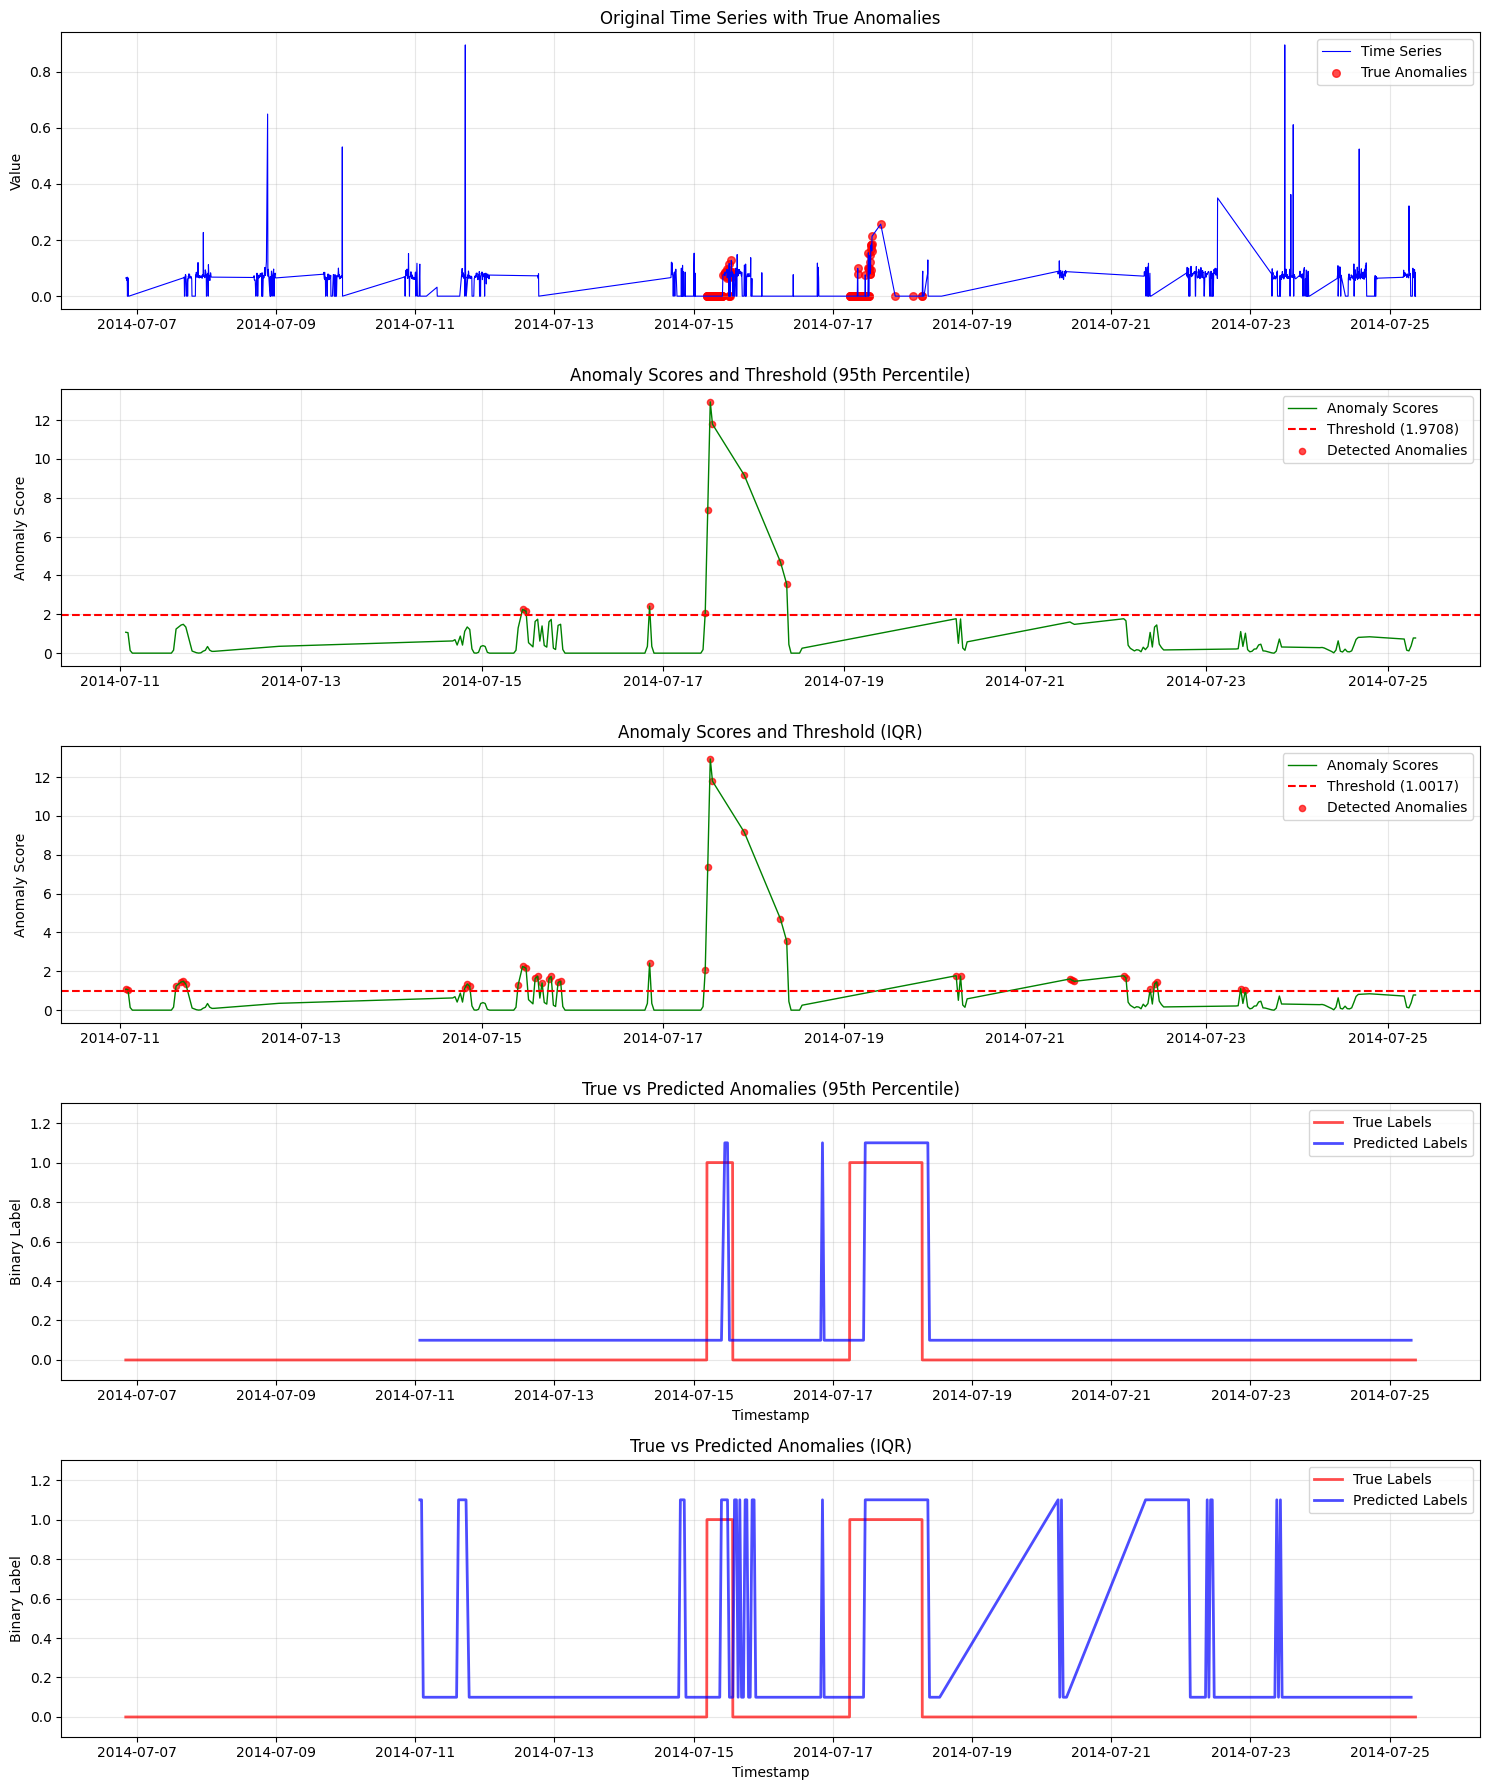

In [56]:
plot_results(df, labels, anomaly_scores_smooth, threshold_p95, threshold_iqr,
             "Chronos Anomaly Detection - 95th Percentile Threshold")

In [61]:
# === Step 9: Metriche di valutazione ===
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, confusion_matrix

def evaluate_anomaly_detection(true_labels, anomaly_scores, threshold):
    """
    Valuta le performance dell'anomaly detection
    """
    # Gestisci NaN
    valid_mask = ~np.isnan(anomaly_scores)
    true_labels_valid = true_labels[valid_mask]
    predictions = (anomaly_scores[valid_mask] > threshold).astype(int)
    scores_valid = anomaly_scores[valid_mask]

    if len(predictions) == 0:
        return None

    # Metriche binarie
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels_valid, predictions, average='binary', zero_division=0
    )

    # ROC AUC (se abbiamo entrambe le classi)
    try:
        auc = roc_auc_score(true_labels_valid, scores_valid)
    except:
        auc = 0.0

    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(true_labels_valid, predictions).ravel()

    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc,
        'true_positives': tp,
        'false_positives': fp,
        'true_negatives': tn,
        'false_negatives': fn,
        'threshold': threshold
    }

# Valuta con diverse soglie
results = {}
thresholds = {
    'percentile_95': threshold_p95,
    'iqr': threshold_iqr
}

print("\n=== EVALUATION RESULTS ===")
for name, thresh in thresholds.items():
    result = evaluate_anomaly_detection(labels, anomaly_scores_smooth, thresh)
    if result:
        results[name] = result
        print(f"\n{name.upper()} (threshold: {thresh:.4f}):")
        print(f"  Precision: {result['precision']:.3f}")
        print(f"  Recall: {result['recall']:.3f}")
        print(f"  F1-Score: {result['f1_score']:.3f}")
        print(f"  AUC: {result['auc']:.3f}")
        print(f"  TP: {result['true_positives']}, FP: {result['false_positives']}")
        print(f"  TN: {result['true_negatives']}, FN: {result['false_negatives']}")

# Salva risultati
output_data = {
    'timestamps': df['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S').tolist(),
    'values': df['value'].tolist(),
    'true_labels': labels.tolist(),
    'anomaly_scores': [float(x) if not np.isnan(x) else None for x in anomaly_scores_smooth],
    'thresholds': thresholds,
    'evaluation_results': results
}

print(f"\nAnomaly detection completato!")
print(f"Total data points: {len(df)}")
print(f"Valid anomaly scores: {np.sum(~np.isnan(anomaly_scores_smooth))}")
print(f"True anomalies: {np.sum(labels)}")


=== EVALUATION RESULTS ===

PERCENTILE_95 (threshold: 1.9708):
  Precision: 0.700
  Recall: 0.259
  F1-Score: 0.378
  AUC: 0.489
  TP: 7, FP: 3
  TN: 194, FN: 20

IQR (threshold: 1.0017):
  Precision: 0.205
  Recall: 0.296
  F1-Score: 0.242
  AUC: 0.489
  TP: 8, FP: 31
  TN: 166, FN: 19

Anomaly detection completato!
Total data points: 1882
Valid anomaly scores: 224
True anomalies: 190


In [58]:
def rolling_zscore(x, win=120, k=3.0):
    mu  = x.rolling(win, center=True).mean()
    sig = x.rolling(win, center=True).std(ddof=0)
    score = (x - mu) / (sig + 1e-9)
    return (score.abs() >= k).astype(int)   # 1 = anomalia

def sma_residual(x, win=120, k=3.0):
    sma   = x.rolling(win, center=True).mean()
    resid = (x - sma).abs()
    thr   = k * resid.rolling(win, center=True).std(ddof=0)  # banda adattiva
    return (resid >= thr).astype(int)

zscore = rolling_zscore(df['value'], win=context_length, k=2.0)
sma = sma_residual(df['value'], win=context_length, k=2.0)

#conta anomalie in zscore
print(len(zscore),len(zscore[zscore == 1]))  # conta le anomalie
# conta anomalie in sma
print(len(sma),len(sma[sma == 1]))  # conta le anomalie




from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_auc_score

def evaluate_with_mask(y_true, scores_or_pred, *, thr=None, mask=None, name=""):
    """
    Se thr=None interpreto scores_or_pred già binari (0/1).
    Altrimenti applico la soglia thr > score per ottenere le predizioni.
    mask=True/False indica i punti su cui valutare (es. dove Chronos non ha fatto skip).
    """
    if mask is None:
        mask = np.ones_like(y_true, dtype=bool)

    y_true_m = y_true[mask]
    data_m   = scores_or_pred[mask]

    if thr is None:                         # vettore binario già pronto
        y_pred = data_m.astype(int)
    else:                                   # score continuo + soglia
        y_pred = (data_m > thr).astype(int)

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true_m, y_pred, average='binary', zero_division=0
    )

    # ROC-AUC solo se abbiamo score continui e >1 classe
    auc = 0.0
    if thr is not None and len(np.unique(y_true_m)) > 1:
        try:
            auc = roc_auc_score(y_true_m, data_m)
        except ValueError:
            pass

    tn, fp, fn, tp = confusion_matrix(y_true_m, y_pred).ravel()

    print(f"\n{name} :")
    print(f"  Precision: {precision:.3f}  Recall: {recall:.3f}  F1: {f1:.3f}  AUC: {auc:.3f}")
    print(f"  TP:{tp} FP:{fp}  TN:{tn} FN:{fn}")

    return dict(precision=precision, recall=recall, f1_score=f1, auc=auc,
                tp=tp, fp=fp, tn=tn, fn=fn)


# maschera dove Chronos ha emesso score
valid_mask = ~np.isnan(anomaly_scores_smooth)

# 2a. ROLLING Z-SCORE (già binario)
pred_z = rolling_zscore(df["value"], win=120, k=2.0).values
evaluate_with_mask(labels, pred_z, thr=None, mask=valid_mask, name="ROLLING Z-SCORE")

# 2b. SMA RESIDUAL (già binario)
pred_sma = sma_residual(df["value"], win=120, k=2).values
evaluate_with_mask(labels, pred_sma, thr=None, mask=valid_mask, name="SMA RESIDUAL")



def generate_binary_labels(df, anomaly_windows):
    labels = np.zeros(len(df), dtype=int)
    for start_str, end_str in anomaly_windows:
        start = pd.to_datetime(start_str)
        end = pd.to_datetime(end_str)
        mask = (df['timestamp'] >= start) & (df['timestamp'] <= end)
        labels[mask] = 1
    return labels

with open("anomaly_data/combined_windows.json", "r") as f:
    labels_json = json.load(f)

anomaly_windows = labels_json["realKnownCause/rogue_agent_key_hold.csv"]
labels = generate_binary_labels(df, anomaly_windows)

# evaluate_binary(labels, zscore, "Z-Score")
# evaluate_binary(labels, sma, "SMA Residual")


1882 29
1882 142

ROLLING Z-SCORE :
  Precision: 0.333  Recall: 0.037  F1: 0.067  AUC: 0.000
  TP:1 FP:2  TN:195 FN:26

SMA RESIDUAL :
  Precision: 0.300  Recall: 0.222  F1: 0.255  AUC: 0.000
  TP:6 FP:14  TN:183 FN:21
